# Connect4 DQN model
By LaughingSkull 
as new RL agent for my game COnnect-4: https://www.laughingskull.org/Games/Connect4/Connect4.php


## DQN (Deep Q-Network)

* A value-based reinforcement learning method.
* Uses a neural network to approximate the Q-function: estimates the expected future rewards for taking actions in given states.
* Learns via Q-learning: updates the Q-values using the Bellman equation.
* Typically uses techniques like experience replay and target networks to stabilize training.

### version log    

* 0.8.0 - start with new convolutional part
    * keeping L2 regularization
* 0.9.0 - extension to shallow training
* 0.10.0 - extension to L3 training
    * NO PRUNE:
        * worse 
    * SHARPer PRUNE
    * extend phases
        * MixedR12: no improvement; &cross;
        * Shallow
        * Fixed2
        * Variable23
        * Variable3
* 0.11.0 - recover fixed 2
    * corrected reward leaking bug
    * corrected draw bug
* 0.12.0 refactoring and restarting
* 0.13 restarting again
    * strategy weights djustment
* 0.14 new restart from scratch
    * intermediate phases
* 0.15 shaped rewards
* 0.16 testing target_update_interval
* 0.17 changing CNN
* 0.18 8-part weights approach, rebalancing and restarting (again)
    * frozen model for self play
    * adding mirrored rewards
    * adding player POV then getting rid of it
        * splitting agent  and oppo players channel
* 0.19 restart with tweaking weights (again)
    * new ENV step weights
    * added forking and fork blocking
    * included forks in lookahead
* 0.20 adding PER - prioritized experience replay
    * retuning phases and weights (yet again)
    * adding immediate win penalty in env
* 0.21 3-step returns
* 0.22 tactical guard
    * random 10%
    * changed evaluation
    * restart
    * rewards less defensive as before, but more as attack
    * corrected pov in n-step
* 0.23 tune to stabilize TD error, TU tuning
* 0.24 training phase tuning
    * removed history based memory prune
    * priority based memory pruning
* 0.25 optimistic weight initialization
    * small penalty per step - train faster bastard!
* 0.30 seeded start using game states from DATA generator
  

## Links, learning from

[https://github.com/t-brewer/connect4_CNN](https://github.com/t-brewer/connect4_CNN)
<br>

[https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html](https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
<br>
[https://pettingzoo.farama.org/tutorials/agilerl/DQN/](https://pettingzoo.farama.org/tutorials/agilerl/DQN/)
<br>
[https://www.geeksforgeeks.org/machine-learning/understanding-prioritized-experience-replay/](https://www.geeksforgeeks.org/machine-learning/understanding-prioritized-experience-replay/)
<br>
### Other helpful links

<br>[https://medium.com/@vishwapatel214/building-a-connect-4-game-bot-with-deep-learning-models-dbcd019d8967](https://medium.com/@vishwapatel214/building-a-connect-4-game-bot-with-deep-learning-models-dbcd019d8967)
<br>[https://codebox.net/pages/connect4#:~:text=This%20requires%20a%20lot%20of%20work%20up%2Dfront,possible%20action%20at%20each%20step%20is%20impractical.](https://codebox.net/pages/connect4#:~:text=This%20requires%20a%20lot%20of%20work%20up%2Dfront,possible%20action%20at%20each%20step%20is%20impractical.)
<br>[https://medium.com/advanced-machine-learning/deep-learning-meets-board-games-creating-a-connect-4-ai-using-cnns-and-vits-89c8cdab0041](https://medium.com/advanced-machine-learning/deep-learning-meets-board-games-creating-a-connect-4-ai-using-cnns-and-vits-89c8cdab0041)
<br>[https://medium.com/@piyushkashyap045/understanding-dropout-in-deep-learning-a-guide-to-reducing-overfitting-26cbb68d5575#:~:text=Choosing%20Dropout%20Rate:%20Common%20dropout,is%20better%20for%20simpler%20models.](https://medium.com/@piyushkashyap045/understanding-dropout-in-deep-learning-a-guide-to-reducing-overfitting-26cbb68d5575#:~:text=Choosing%20Dropout%20Rate:%20Common%20dropout,is%20better%20for%20simpler%20models.)
<br>
[https://medium.com/oracledevs/lessons-from-alphazero-connect-four-e4a0ae82af68](https://medium.com/oracledevs/lessons-from-alphazero-connect-four-e4a0ae82af68)
<br>
[https://docs.agilerl.com/en/latest/tutorials/pettingzoo/dqn.html](https://docs.agilerl.com/en/latest/tutorials/pettingzoo/dqn.html)
<br>



## Import dependecies and recheck installation

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import pprint;
import pandas as pd
import os
import json
from copy import deepcopy
from collections import deque
from IPython.display import display, clear_output, HTML

print("All dependencies imported successfully.")
print("torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("CUDA not available. Using CPU.")


All dependencies imported successfully.
torch version: 2.5.1
CUDA available: True
CUDA version: 11.8
GPU name: NVIDIA GeForce RTX 4090


### Fixed Random seeds

In [2]:
SEED = 666
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(SEED)

In [3]:
LOG_DIR ="Logs/DQN/"
MODEL_DIR ="Models/DQN/"
PLOTS = "Plots/DQN/"

## Custom imports

In [4]:
from C4.connect4_env import Connect4Env
from C4.connect4_lookahead import Connect4Lookahead
from DQN.training_phases_config import TRAINING_PHASES
from DQN.training_phases_config import set_training_phases_length
from DQN.opponent_action import get_opponent_action
from DQN.DQN_replay_memory_per import PrioritizedReplayMemory
from DQN.dqn_model import DQN
from DQN.dqn_agent import DQNAgent
from DQN.dqn_utilities import *
from C4.connect4_board_display import Connect4_BoardDisplayer
from C4.plot_phase_summary import plot_phase_summary
from DQN.nstep_buffer import NStepBuffer
from DQN.eval_utilities import build_input, evaluate_with_leaks
from DQN.TD_error import *
from DQN.c4_seed_util import seed_from_dataframe

Lookahead = Connect4Lookahead()

# Training phases

In [5]:
set_training_phases_length(TRAINING_PHASES)

,length,duration,epsilon,epsilon_min,memory_prune_low,sumWeights,sumOppo
Random1,300,300,0.25,0.10,0.00,1.0,1.0
Random2,600,300,0.25,0.10,0.00,1.0,1.0
Mixed_R1_Attack,1000,400,0.40,0.10,0.00,1.0,1.0
Mixed_R1_Defense,1600,600,0.40,0.10,0.05,1.0,1.0
Mixed_R1_Equal,2200,600,0.40,0.10,0.05,1.0,1.0
Mixed_R1_Conclude,2600,400,0.40,0.10,0.05,1.0,1.0
SelfPlay_Mixed_R1,3000,400,0.02,0.02,0.05,0.0,0.0
Mixed_R11_Attack,3500,500,0.40,0.05,0.05,1.0,1.0
Mixed_R11_Defense,4000,500,0.40,0.05,0.05,1.0,1.0
Mixed_R11_Equal,4500,500,0.40,0.05,0.05,1.0,1.0


# Training session name and settings

In [6]:
lookahead_depth = 7  # prophet = 7
num_episodes = 13800
batch_size = 128
target_update_interval = 200
plot_interval = 10
log_every_x_episode = 100
tag = "SelfPlay_L2"

TRAINING_SESSION = f"{tag}-{num_episodes}-TU-{target_update_interval}-BS-{batch_size}"
begin_start_time = time.time()

print("Started training session", TRAINING_SESSION)

#DEV
PLOT_TD = True
num_episodes -= 1 # debug
#num_episodes = max(num_episodes, 101) #debug  safeguard

Started training session SelfPlay_L2-13800-TU-200-BS-128


### Training config

In [7]:
# --- Save training configuration to Excel ---
from C4.training_config_logger import export_training_config

paths = export_training_config(
    training_phases=TRAINING_PHASES,
    lookahead_depth=lookahead_depth,
    num_episodes=num_episodes,
    batch_size=batch_size,
    target_update_interval=target_update_interval,
    log_dir=LOG_DIR,
    session_name=TRAINING_SESSION,
    write_excel=True,    # set False if you only want CSV/JSON
    write_json=False,     # handy for exact reproduction later
)

print("config written:", paths)

config written: {'excel': 'Logs/DQN/DQN-SelfPlay_L2-13800-TU-200-BS-128_training_config.xlsx'}


### Model overview

In [8]:
_model = DQN()
summary(_model, input_size=(1, 2, 6, 7))  # batch=1, channels=2, height=6, width=7

Layer (type:depth-idx)                   Output Shape              Param #
DQN                                      [1, 7]                    --
├─Sequential: 1-1                        [1, 128, 5, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 6, 7]             1,216
│    └─ReLU: 2-2                         [1, 64, 6, 7]             --
│    └─Conv2d: 2-3                       [1, 64, 5, 6]             65,600
│    └─ReLU: 2-4                         [1, 64, 5, 6]             --
│    └─Conv2d: 2-5                       [1, 128, 5, 6]            73,856
│    └─ReLU: 2-6                         [1, 128, 5, 6]            --
├─AdaptiveAvgPool2d: 1-2                 [1, 128, 1, 1]            --
├─Sequential: 1-3                        [1, 1]                    --
│    └─Linear: 2-7                       [1, 64]                   8,256
│    └─ReLU: 2-8                         [1, 64]                   --
│    └─Linear: 2-9                       [1, 1]                    65
├

# Loading Lookahead play data

In [9]:
DATA_FILE = "C4.data.xlsx"
DATA = pd.read_excel(DATA_FILE)
BOARD_COLS = [f"{r}-{c}" for r in range(6) for c in range(7)]
DATA["winner"] = DATA["winner"].astype("int8")
DATA[BOARD_COLS] = DATA[BOARD_COLS].astype("int8")
DATA.tail(5)

,label,winner,0-0,0-1,0-2,0-3,0-4,0-5,0-6,1-0,...,4-4,4-5,4-6,5-0,5-1,5-2,5-3,5-4,5-5,5-6
65,L7L6,0,1,-1,-1,1,-1,1,-1,-1,...,1,-1,1,-1,1,1,1,-1,1,-1
66,L6L7,-1,-1,0,-1,1,1,1,-1,1,...,-1,-1,-1,1,0,-1,1,1,-1,1
67,L6L7,1,0,0,0,-1,0,0,0,0,...,0,0,-1,-1,1,-1,1,0,0,-1
68,L7,-1,0,1,-1,-1,-1,0,-1,0,...,1,-1,-1,0,1,-1,1,-1,1,1
69,L7,-1,1,0,1,-1,1,1,-1,-1,...,1,-1,-1,-1,1,-1,1,-1,1,1


In [10]:
print(f"Rows: {len(DATA)}")
print("Labels:", sorted(DATA['label'].unique().tolist()))
print("Winners distribution:\n", DATA["winner"].value_counts(dropna=False).sort_index())

Rows: 70
Labels: ['L1', 'L1L2', 'L1L3', 'L1L4', 'L1L5', 'L1L6', 'L1L7', 'L2', 'L2L1', 'L2L3', 'L2L4', 'L2L5', 'L2L6', 'L2L7', 'L3', 'L3L1', 'L3L2', 'L3L4', 'L3L5', 'L3L6', 'L3L7', 'L4', 'L4L1', 'L4L2', 'L4L3', 'L4L5', 'L4L6', 'L4L7', 'L5', 'L5L1', 'L5L2', 'L5L3', 'L5L4', 'L5L6', 'L5L7', 'L6', 'L6L1', 'L6L2', 'L6L3', 'L6L4', 'L6L5', 'L6L7', 'L7', 'L7L1', 'L7L2', 'L7L3', 'L7L4', 'L7L5', 'L7L6']
Winners distribution:
 winner
-1    29
 0     8
 1    33
Name: count, dtype: int64


## Training loop - DQN against lookahead opponent (Prophet-style)

### Training loop

In [11]:
summary_stats = {}  
env = Connect4Env()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", device)
agent = DQNAgent(device=device)

N_STEP = 3
seed_start_time = time.time()
agent.memory.begin_seeding()
nstep_buf = seed_from_dataframe(DATA, agent, n_step=N_STEP, gamma=agent.gamma, verbose=True)
agent.memory.end_seeding()
seed_end_time = time.time()
seed_elapsed = seed_end_time - seed_start_time
print(f"Seeding completed in {seed_elapsed:.1f} seconds")

using device: cuda


Seeding: 100%|██████████| 70/70 [00:23<00:00,  3.00it/s]

[seed] games=66, steps=2112, failed=4
Seeding completed in 23.4 minutes


In [12]:
reward_history = []
win_history = []
epsilon_history = []
epsilon_min_history = []
memory_prune_low_history = []

win_count = loss_count = draw_count = 0
phase = None
frozen_opp = None
strategy_weights = []

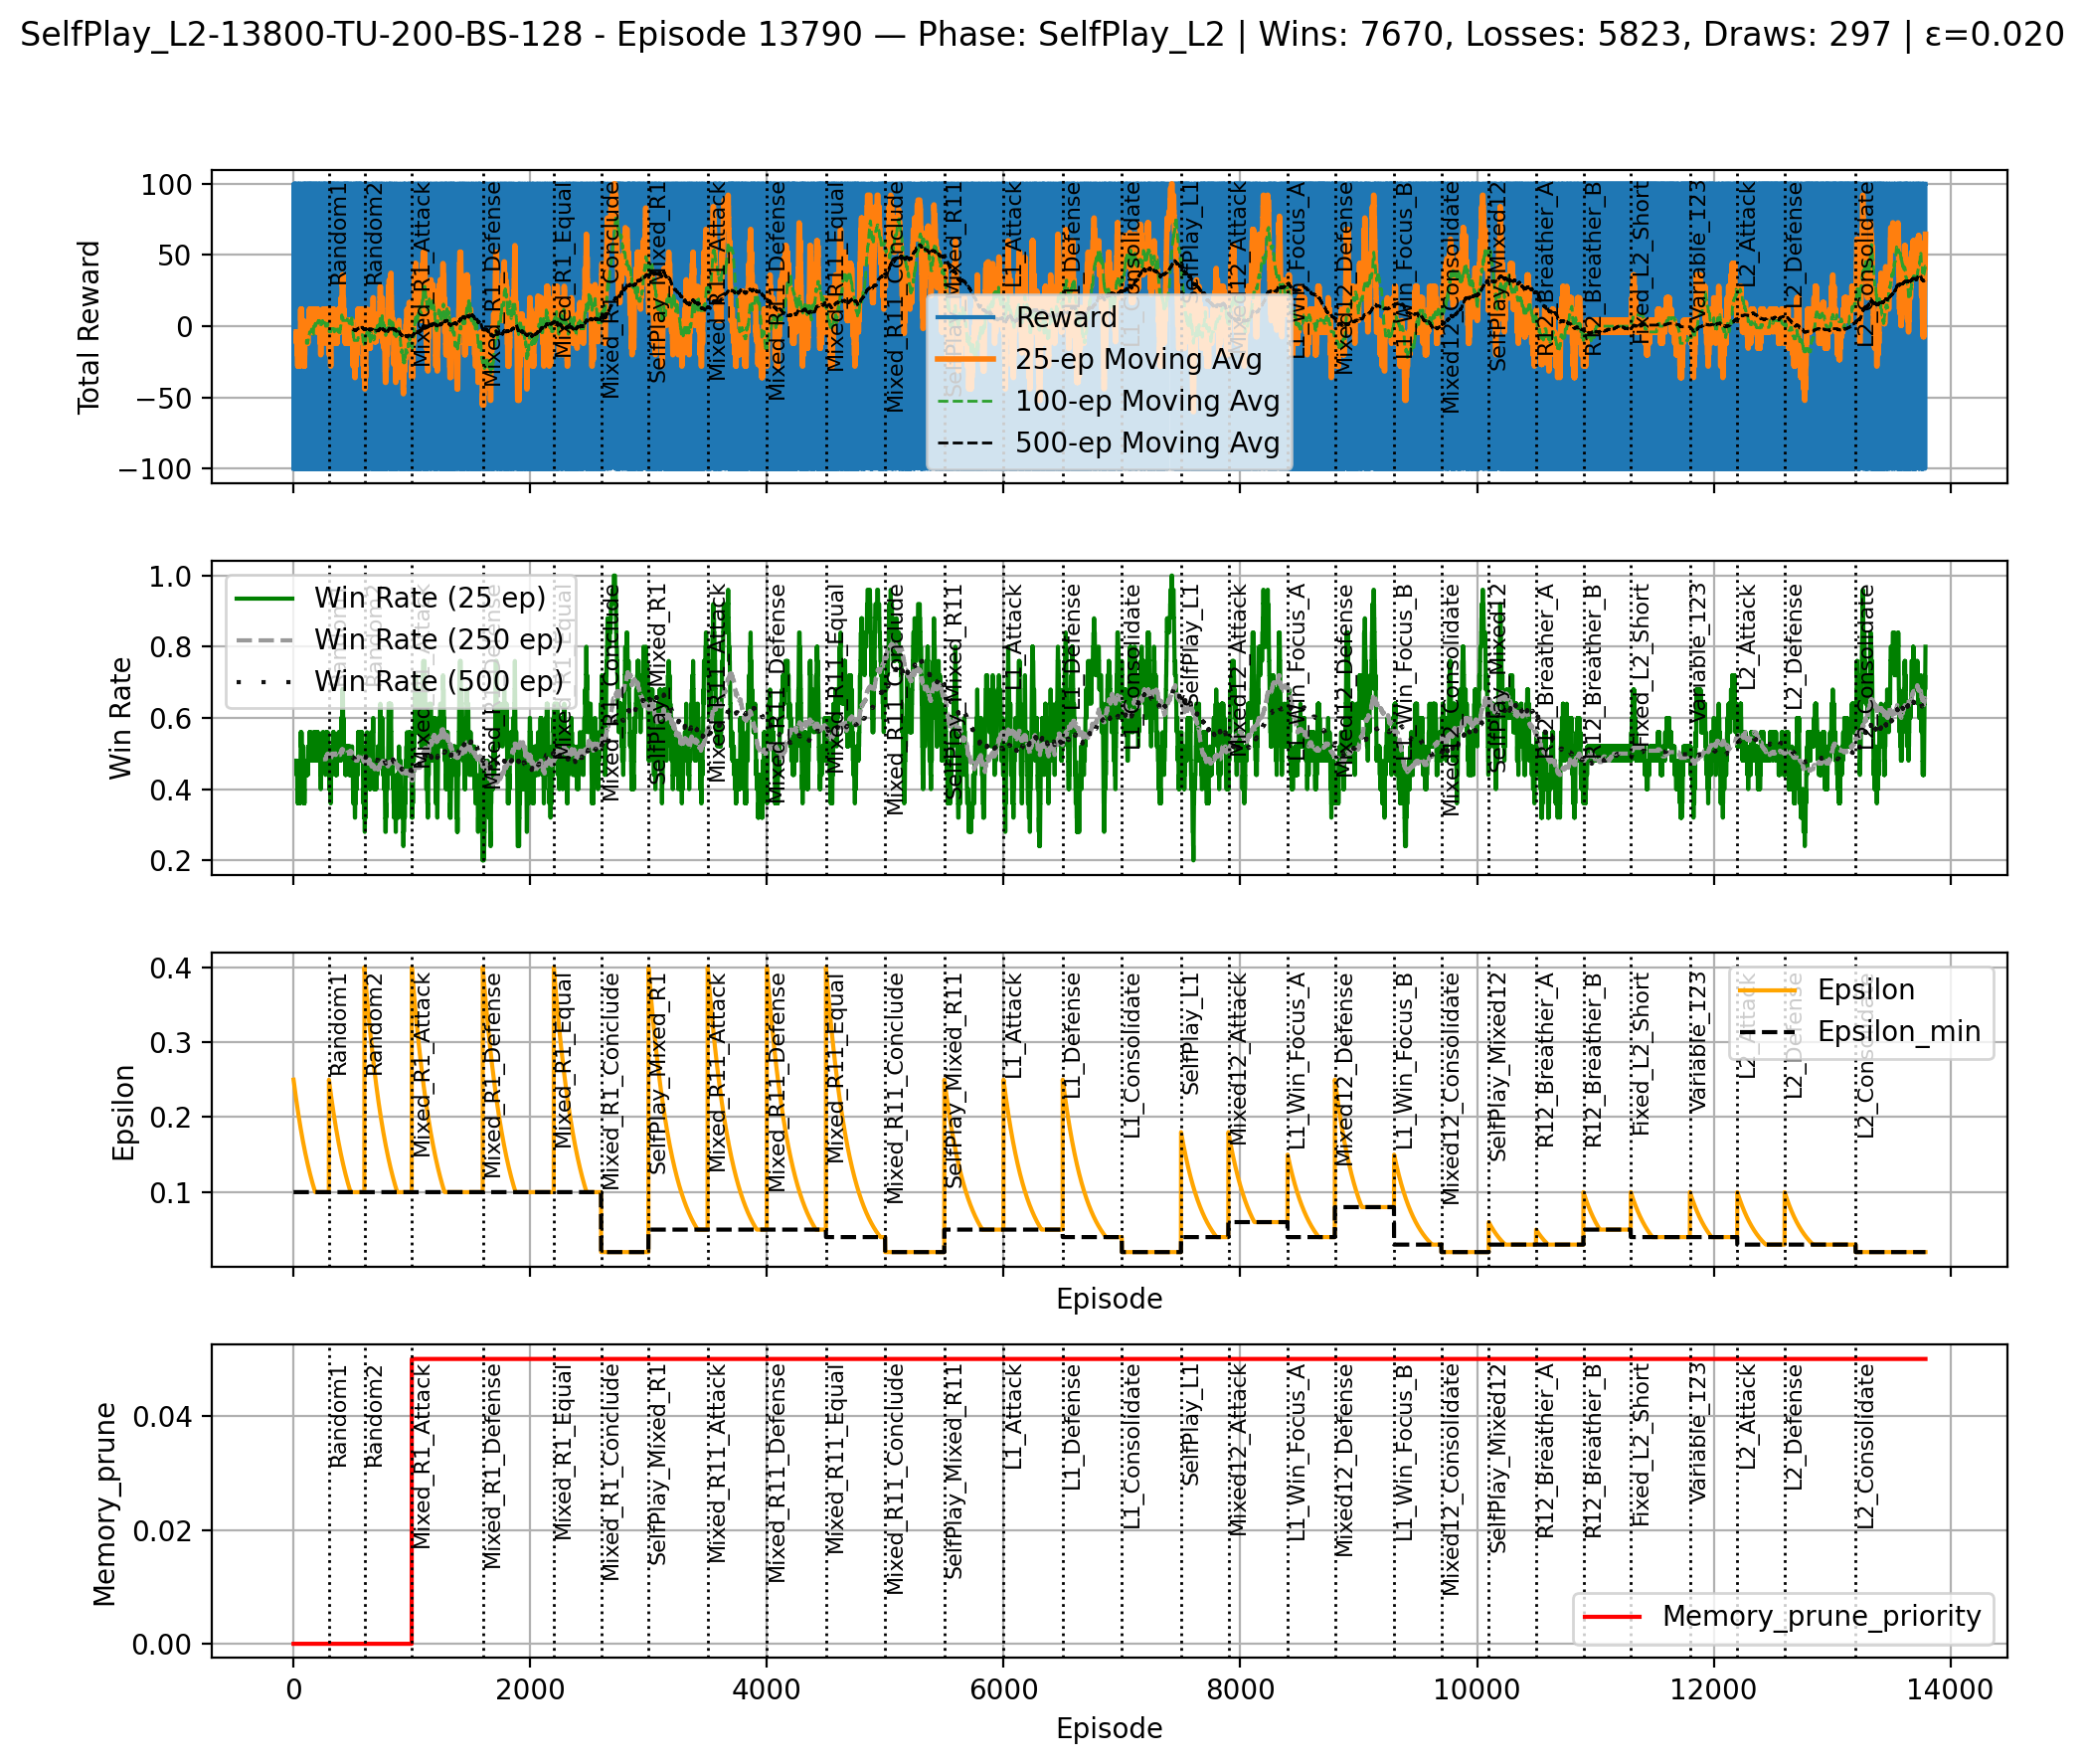

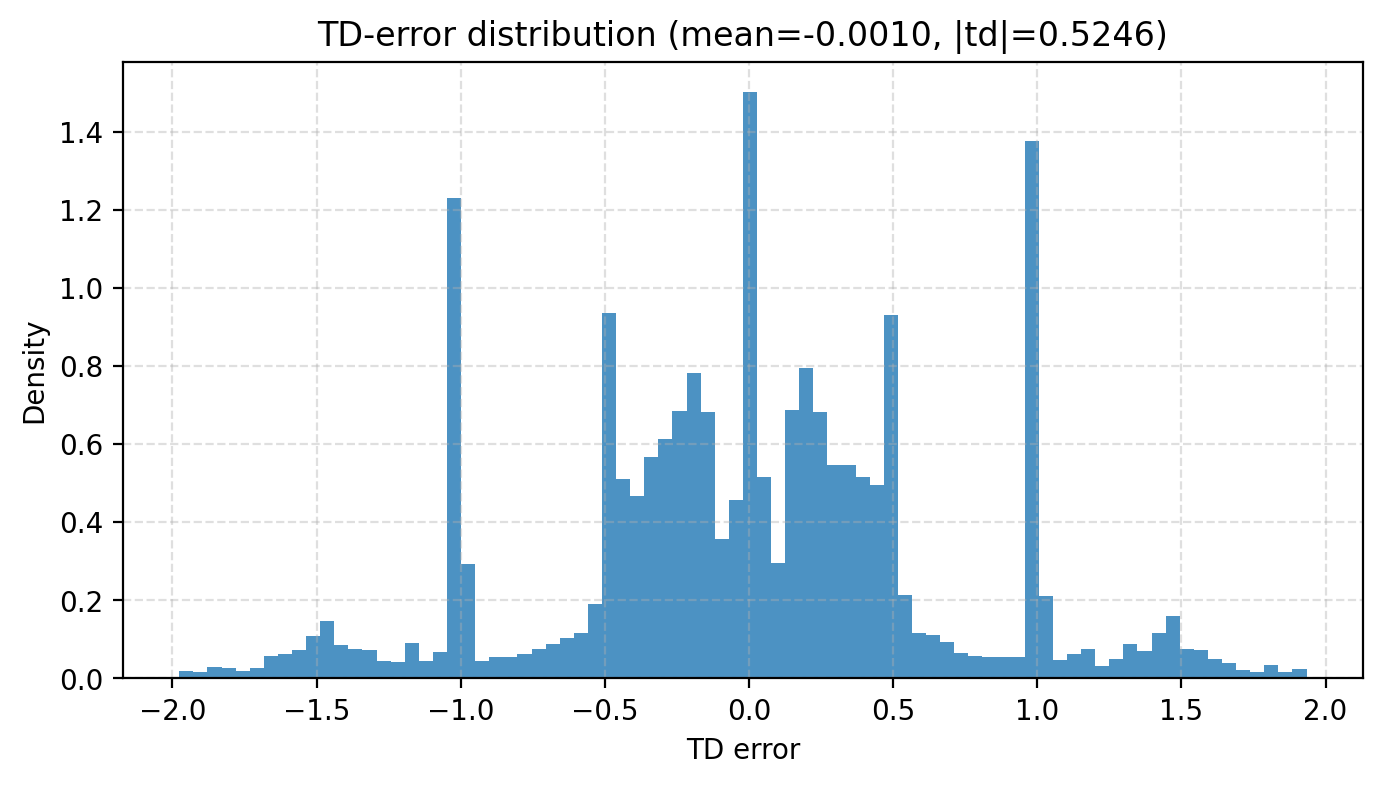

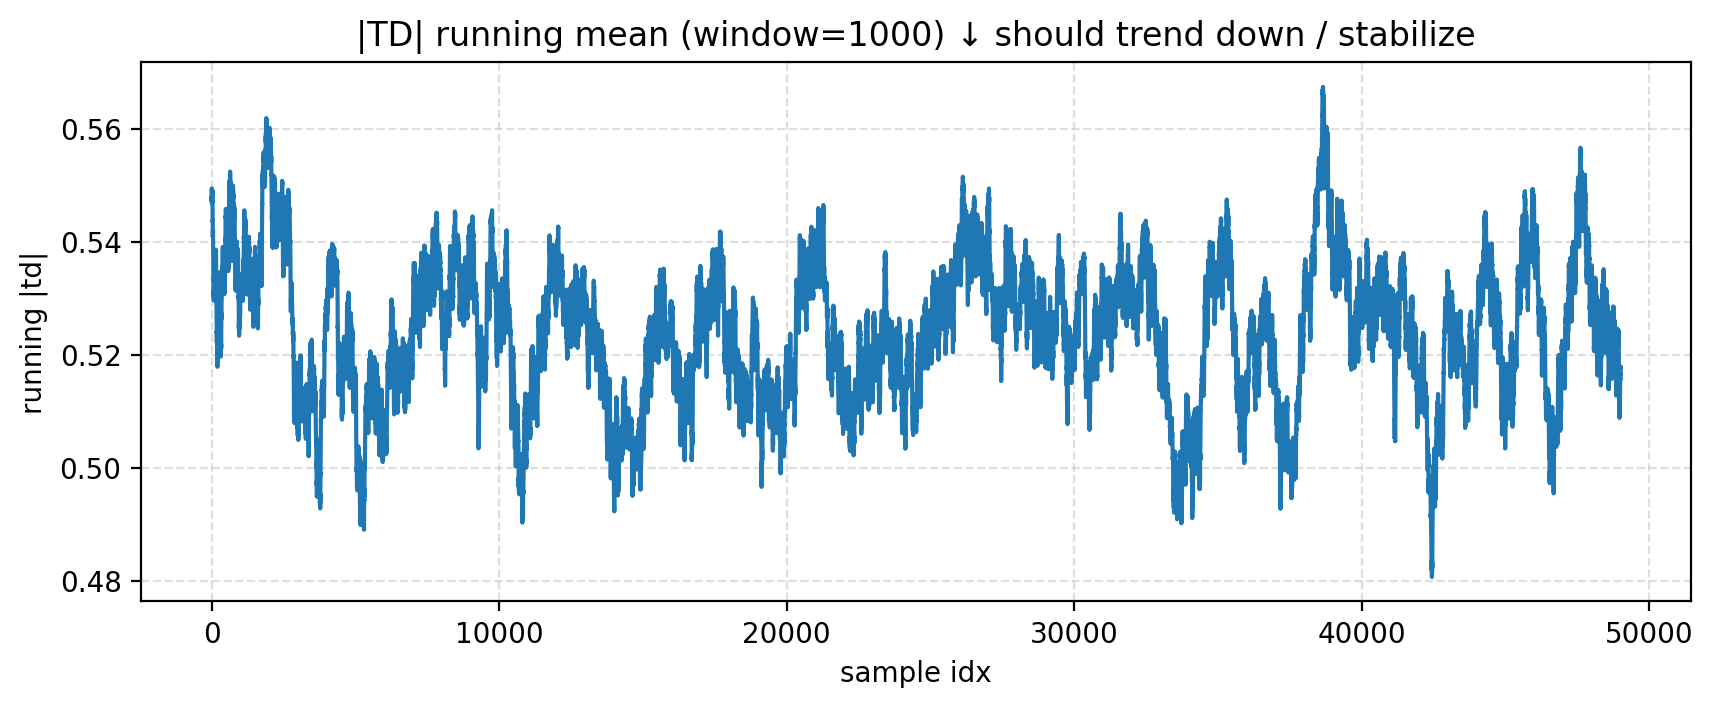

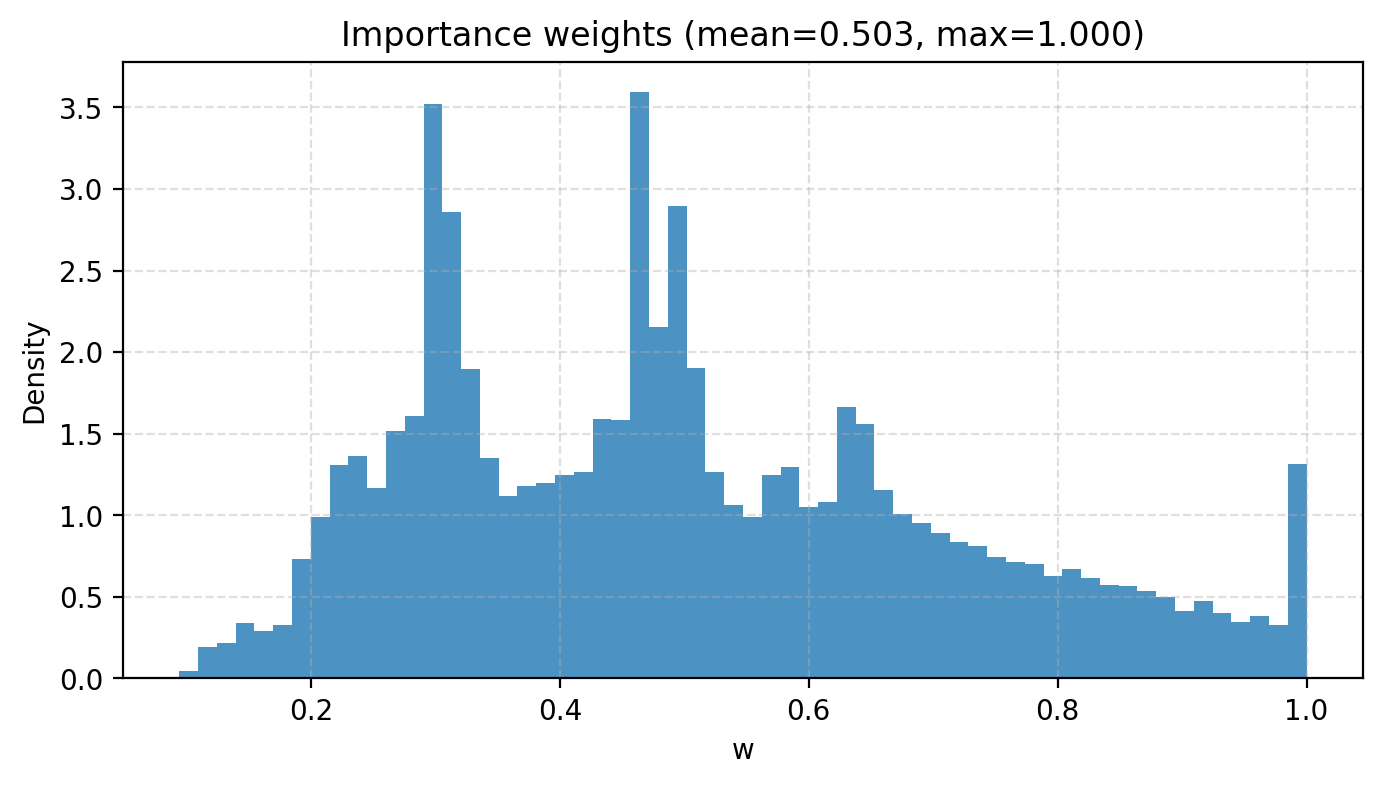

Training Episodes: 100%|█████████▉| 13799/13800 [5:35:55<00:01,  1.46s/it, avg_reward=64.60, draws=297, epsilon=0.020, losses=5823, phase=SelfPlay_L2, wins=7670]


TypeError: cannot unpack non-iterable NoneType object

In [13]:
# === Training loop  ===

start_time = time.time()

with tqdm(total=num_episodes, desc="Training Episodes") as pbar:
    for episode in range(1, num_episodes + 1):
        state = env.reset()
        nstep_buf.reset()  # important: clear rolling window per episode

        total_reward = 0      # terminal reward only
        done = False
        final_result = None   # 1 win, -1 loss, 0.5 draw

        # --- handle phase & hyperparams ---
        new_phase, strategy_weights, epsilon, memory_prune_low, epsilon_min = get_phase(episode)
        phase, frozen_opp = handle_phase_change(
            agent, new_phase, phase, epsilon,
            memory_prune_low, epsilon_min, frozen_opp
        )

        # --------- main training loop ---------
        # alternating start
        if episode % 2 == 1:
            s0 = state
            opp_action = get_opponent_action(env, agent, episode, s0, player=-1,
                                             depth=lookahead_depth, frozen_opp=frozen_opp, phase=phase)
            s1, r_opp, done = env.step(opp_action)
            # append the opponent step
            nstep_buf.append(s0, opp_action, r_opp, s1, done, player=-1)
            state = s1

        # Turn-by-turn until terminal
        while not done:
            # --- Agent (+1) acts ---
            valid_actions = env.available_actions()
            action = agent.act(state, valid_actions, player=+1, depth=lookahead_depth, strategy_weights=strategy_weights)
            next_state, r_agent, done = env.step(action)

            # append agent step
            nstep_buf.append(state, action, r_agent, next_state, done, player=+1)

            if done:
                # terminal on agent move
                final_result = evaluate_final_result(env, agent_player=+1)
                total_reward = map_final_result_to_reward(final_result)
                state = next_state
                break

            # --- Opponent (−1) responds ---
            opp_action = get_opponent_action(env, agent, episode, next_state, player=-1,
                                             depth=lookahead_depth, frozen_opp=frozen_opp, phase=phase)
            next_state2, r_opp, done = env.step(opp_action)

            # append opponent step
            nstep_buf.append(next_state, opp_action, r_opp, next_state2, done, player=-1)

            if done:
                final_result = evaluate_final_result(env, agent_player=+1)
                total_reward = map_final_result_to_reward(final_result)
                state = next_state2
                break

            # continue
            state = next_state2

        # Episode ended — flush remaining short tails so they also yield n-step targets
        nstep_buf.flush()

        # One (or a few) optimization steps
        WARMUP = max(batch_size * 5, 2000)
        UPDATES_PER_EP = 4
        if len(agent.memory) >= WARMUP:
            for _ in range(UPDATES_PER_EP):
                agent.replay(batch_size, mix_1step=0.6)  # try 0.5–0.7
        elif len(agent.memory) >= WARMUP // 2:
            agent.replay(max(batch_size // 2, 32), mix_1step=0.8)


        # --------- bookkeeping ---------
        epsilon_history.append(agent.epsilon)
        epsilon_min_history.append(agent.epsilon_min)
        reward_history.append(total_reward)
        memory_prune_low_history.append(memory_prune_low)

        # Epsilon decay (per episode)
        if agent.epsilon > agent.epsilon_min:
            agent.epsilon *= agent.epsilon_decay
            agent.epsilon = max(agent.epsilon, agent.epsilon_min)

        # Win/loss/draw counters
        wins, losses, draws = track_result(final_result, win_history)
        win_count += wins
        loss_count += losses
        draw_count += draws

        # Target network sync
        if episode % target_update_interval == 0:
            agent.update_target_model()

        # Live plot
        if episode % plot_interval == 0:
            avg_reward = np.mean(reward_history[-25:]) if len(reward_history) >= 1 else 0.0
            pbar.set_postfix(avg_reward=f"{avg_reward:.2f}", epsilon=f"{agent.epsilon:.3f}",
                             wins=win_count, losses=loss_count, draws=draw_count, phase=phase)

            clear_output(wait=True)
            # optional board show:
            # Connect4_BoardDisplayer.display_board(state)
            plot_live_training(
                episode, reward_history, win_history, epsilon_history,
                phase, win_count, loss_count, draw_count, TRAINING_SESSION,
                 epsilon_min_history, memory_prune_low_history
            )

            if PLOT_TD:
                plot_td_error_hist(agent)
                plot_td_running(agent, window=1000)
                plot_is_weights(agent)
                #check_per_priority_correlation(agent, sample=1024)
                #show_sample_mix(agent)

        # Periodic logging
        if episode % log_every_x_episode == 0:
            log_summary_stats(
                episode=episode, reward_history=reward_history, win_history=win_history, phase=phase,
                strategy_weights=strategy_weights, agent=agent, win_count=win_count, loss_count=loss_count,
                draw_count=draw_count, summary_stats_dict=summary_stats
            )
            

        pbar.update(1)

end_time = time.time()
elapsed = end_time - start_time
print(f"\nTraining completed in {elapsed/60:.1f} minutes ({elapsed / num_episodes:.2f} s/episode)")


## Final training plot

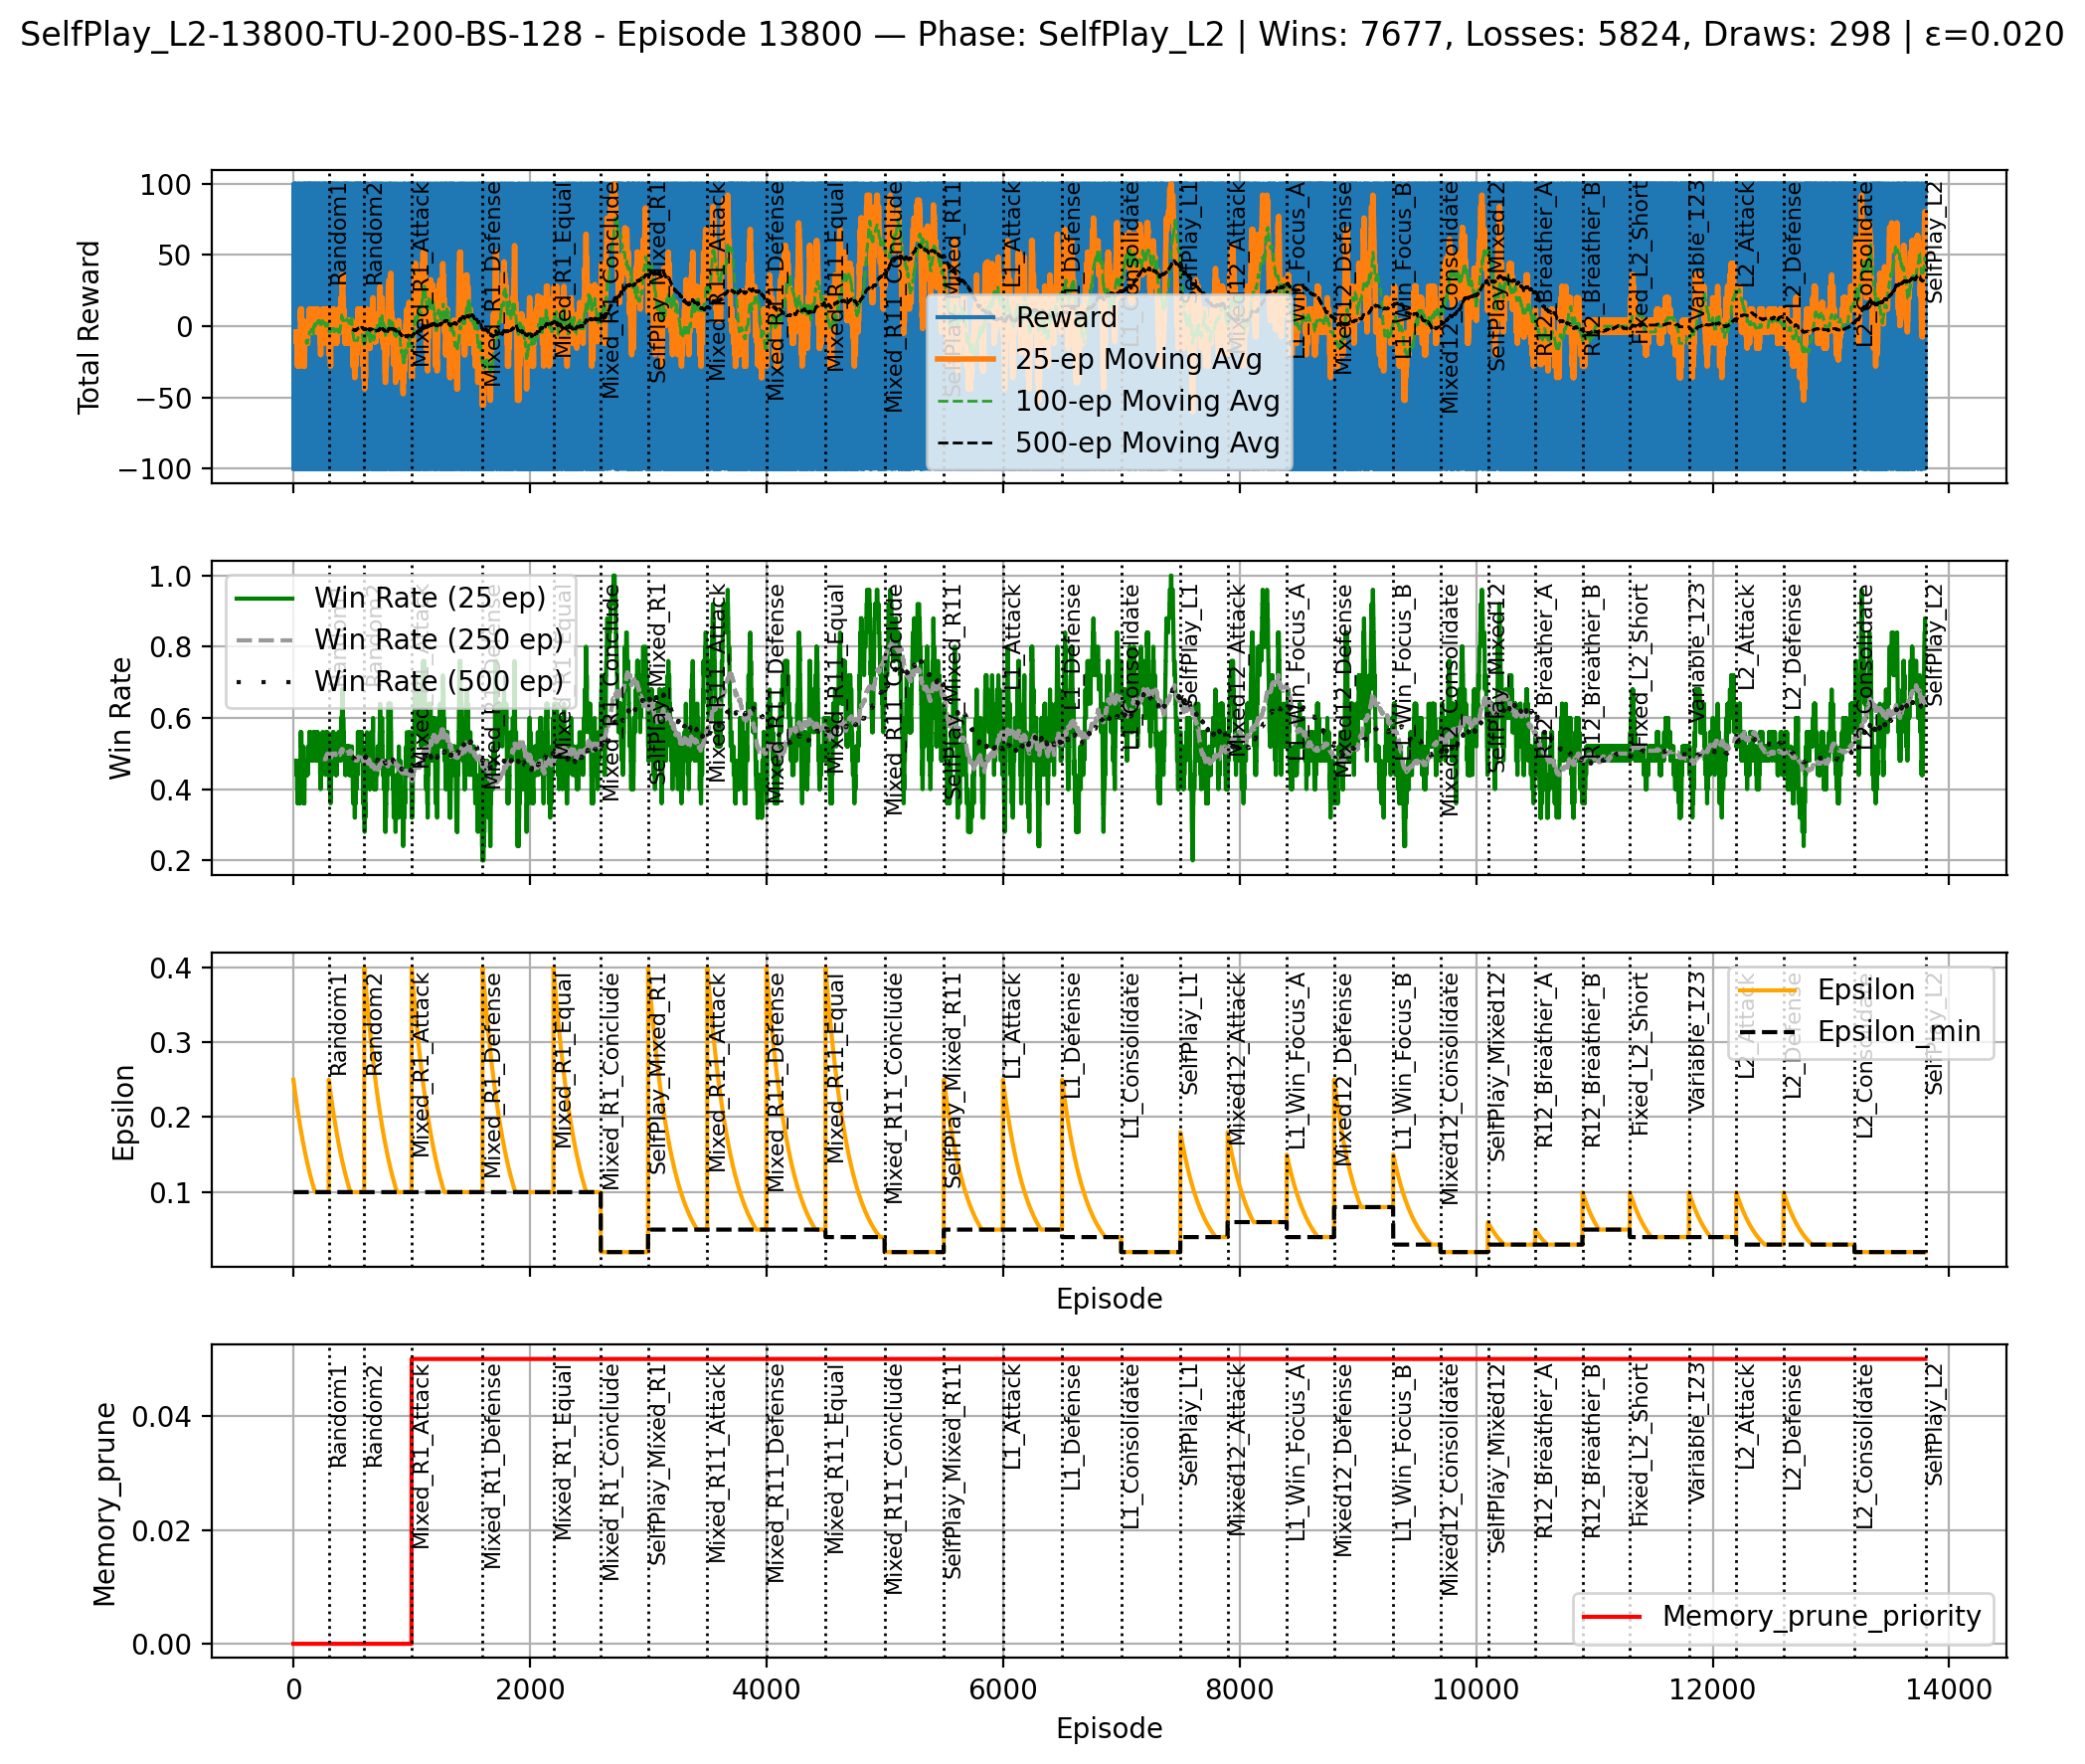

Win rate plot saved to Plots/DQN/SelfPlay_L2-13800-TU-200-BS-128_complete_training_plot.png


In [14]:
 plot_live_training(episode, reward_history, win_history, epsilon_history, 
                               phase, win_count, loss_count, draw_count, TRAINING_SESSION,
                              epsilon_min_history, memory_prune_low_history,
                   save = True, path= PLOTS)

In [15]:
# --- Save final Win Rate plot ---
save_final_winrate_plot(win_history=win_history, training_phases=TRAINING_PHASES, save_path=PLOTS, session_name=TRAINING_SESSION)
print(f"Win rate plot saved to {PLOTS}DQN-{TRAINING_SESSION}_final_winrate.png")

Win rate plot saved to Plots/DQN/DQN-SelfPlay_L2-13800-TU-200-BS-128_final_winrate.png


In [16]:
print(f"\nSummary stats (every {log_every_x_episode} episodes):")
pd.DataFrame.from_dict(summary_stats, orient='index').to_excel(f"{LOG_DIR}DQN-{TRAINING_SESSION}-training_summary.xlsx", index=True)


Summary stats (every 100 episodes):


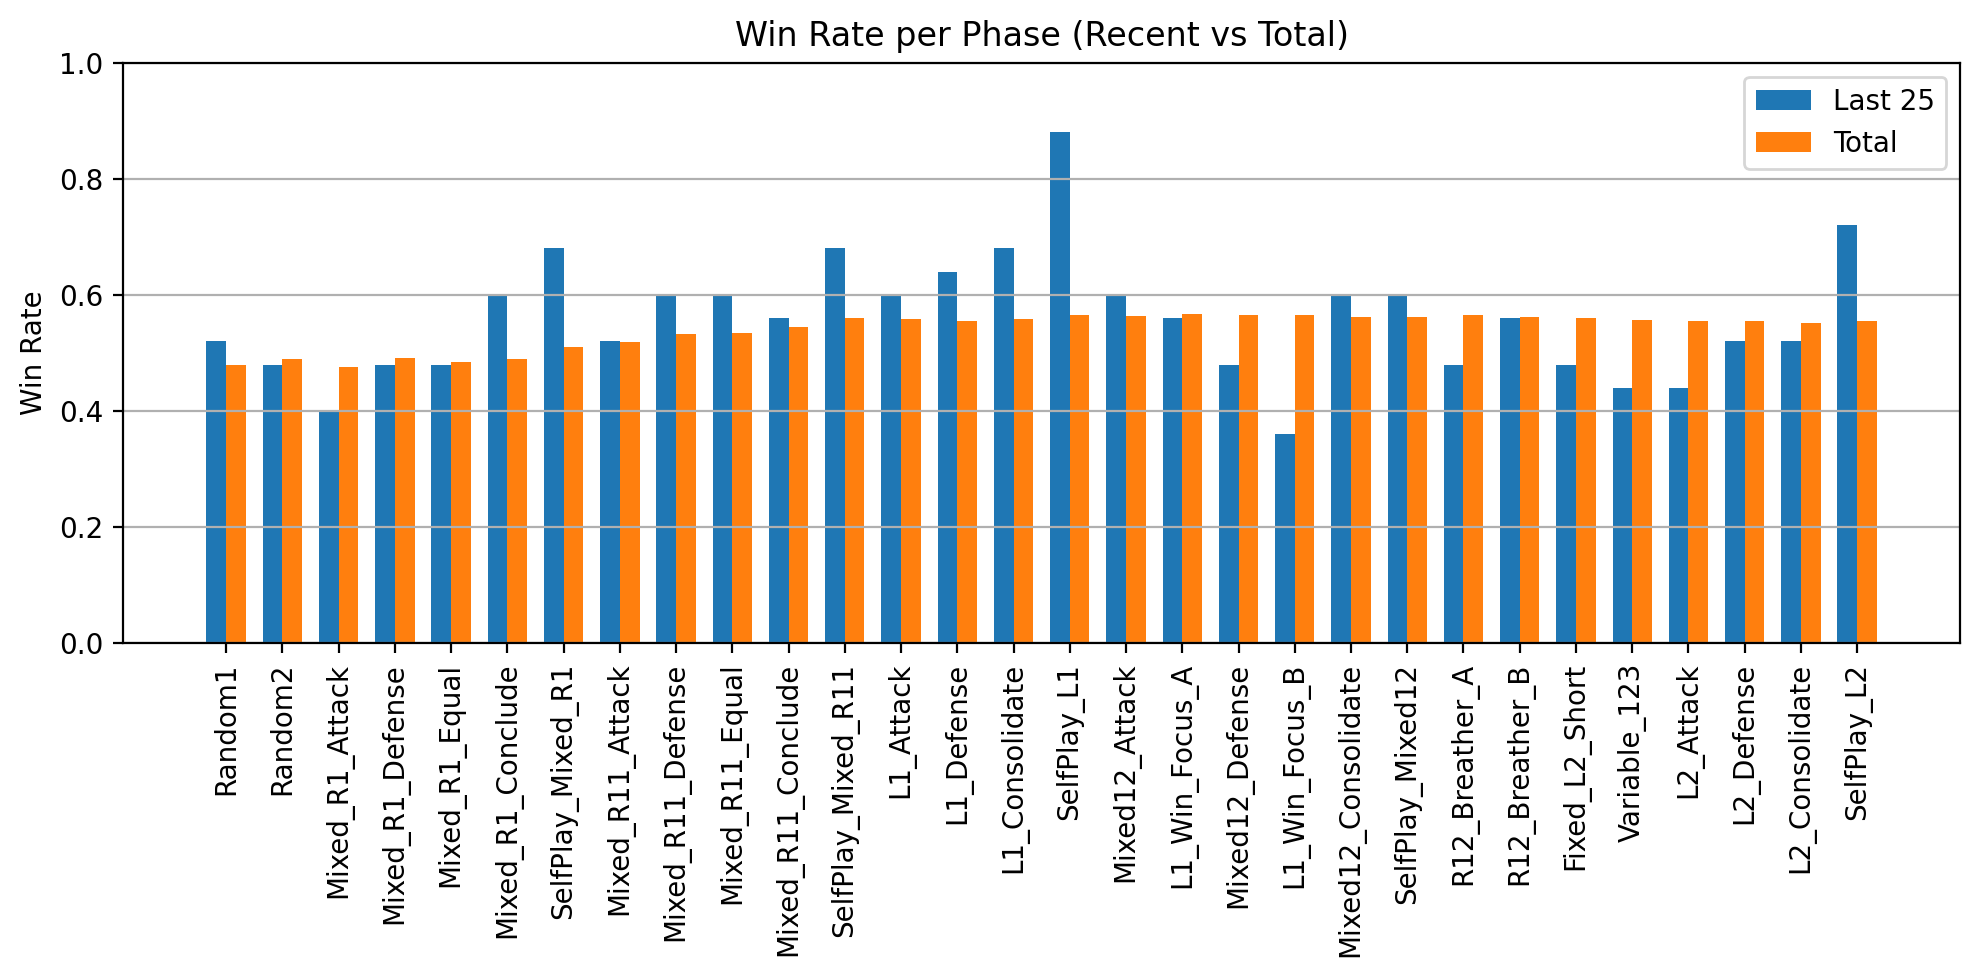

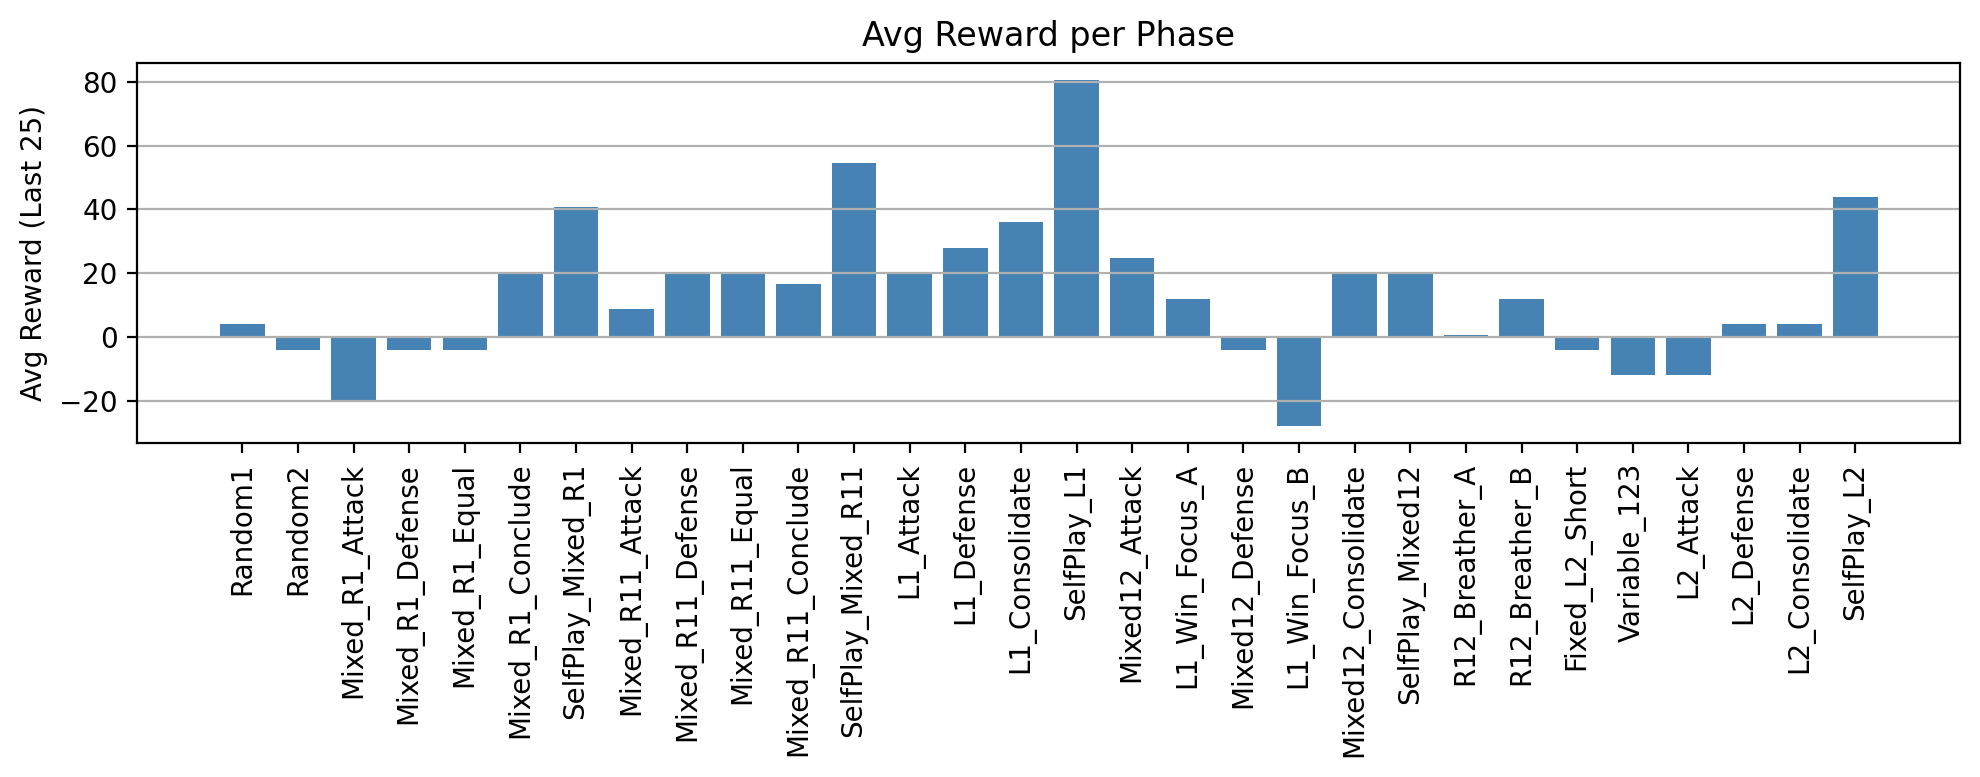

In [17]:
plot_phase_summary(summary_stats, TRAINING_PHASES)

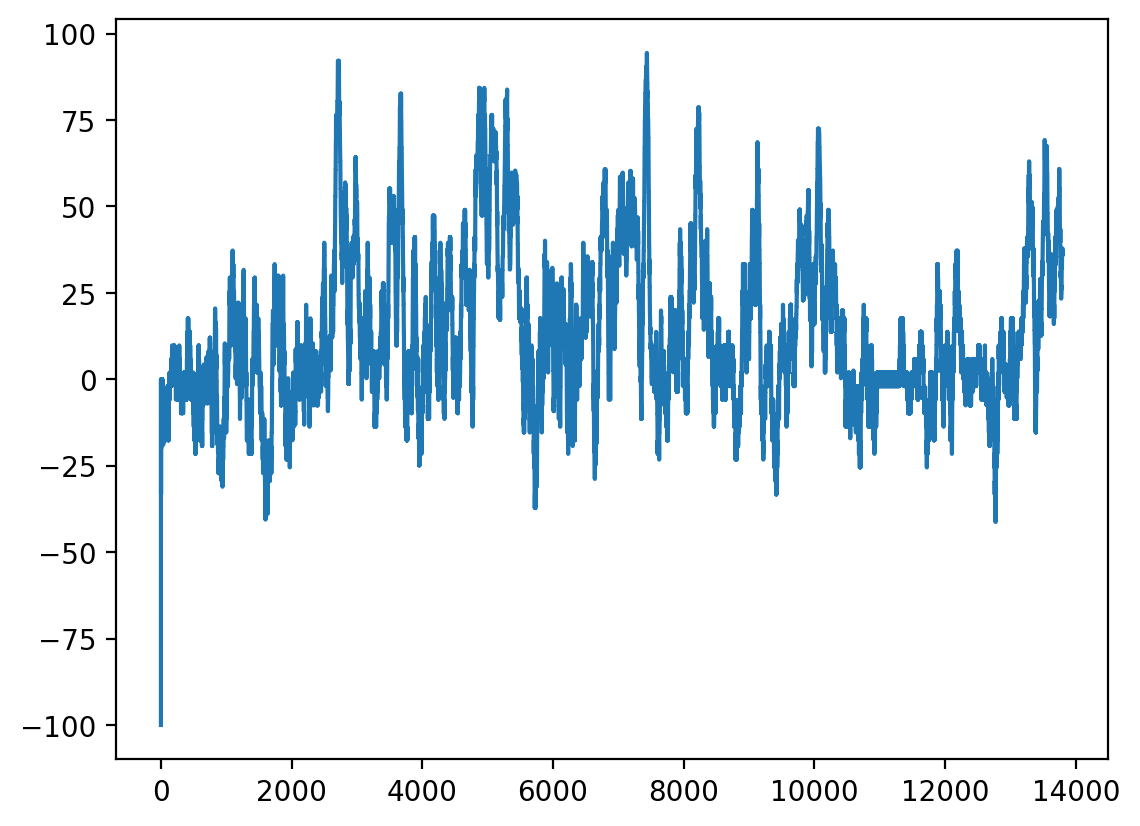

In [18]:
window = 50
smoothed = [np.mean(reward_history[max(0, i-window):i+1]) for i in range(len(reward_history))]
plt.plot(smoothed)
plt.show()

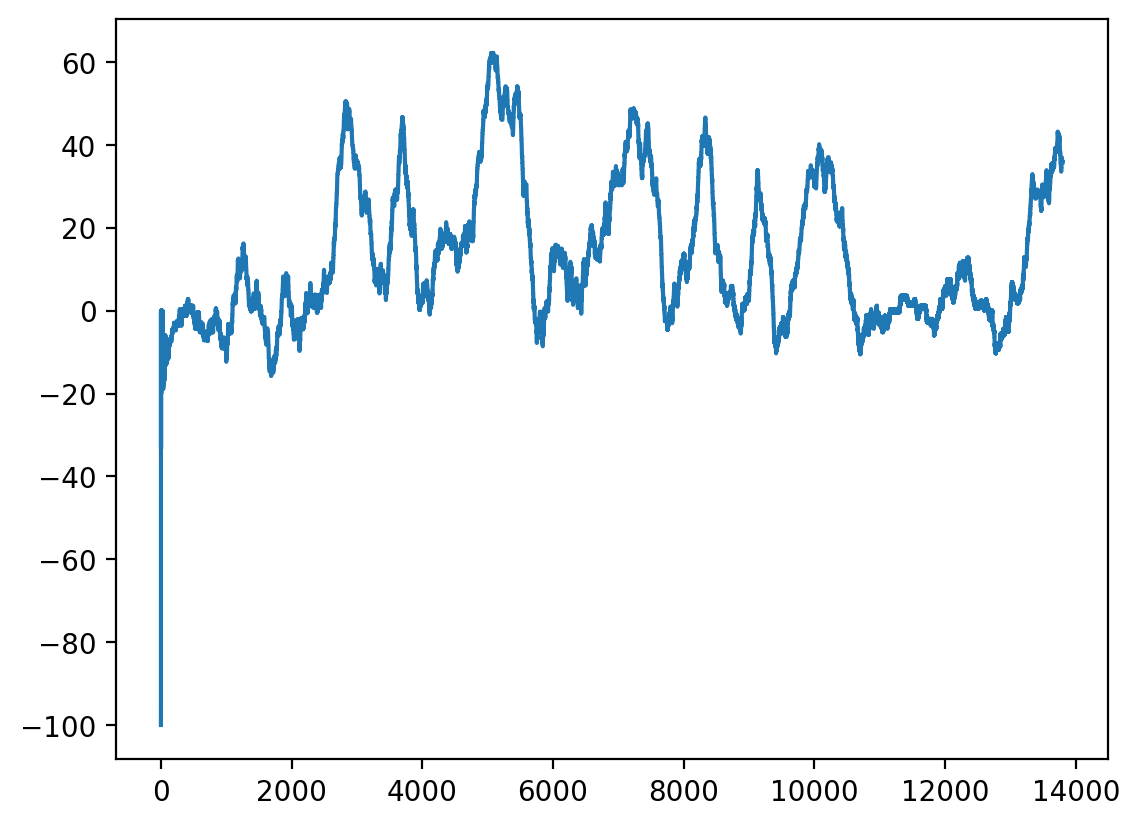

In [19]:
window = 250
smoothed = [np.mean(reward_history[max(0, i-window):i+1]) for i in range(len(reward_history))]
plt.plot(smoothed)
plt.show()

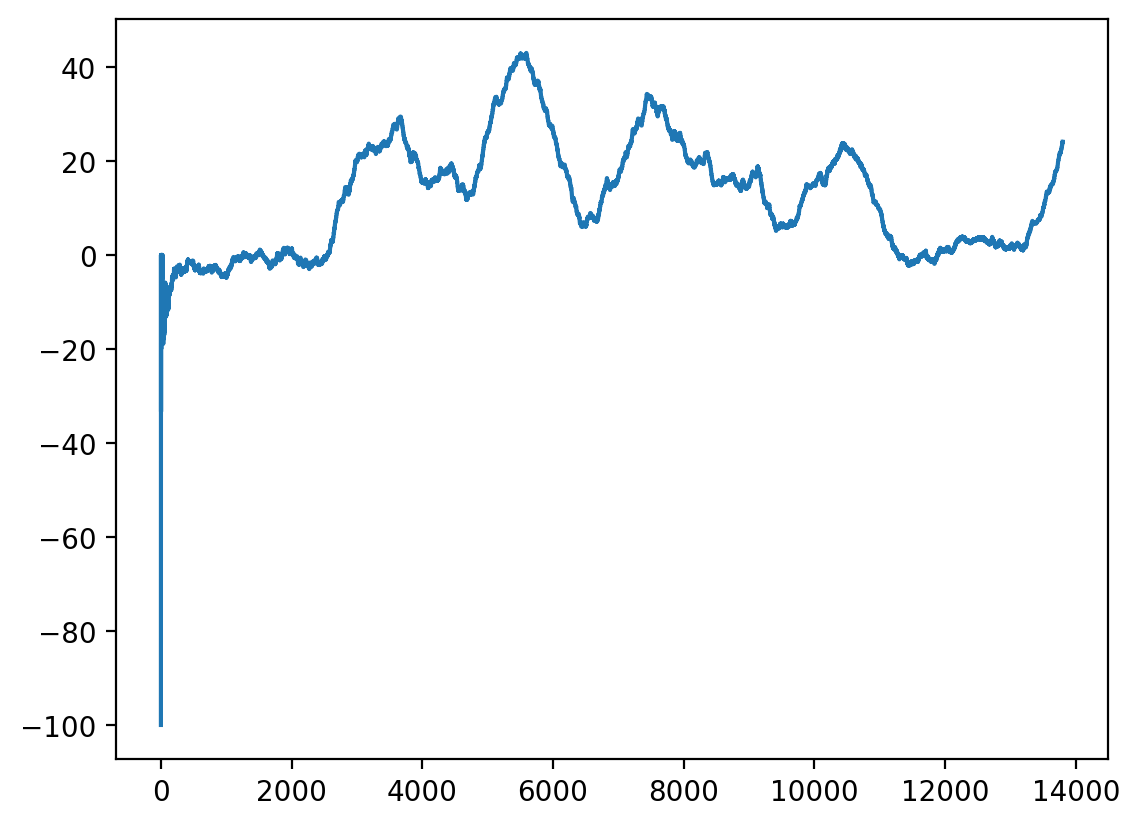

In [20]:
window = 1000
smoothed = [np.mean(reward_history[max(0, i-window):i+1]) for i in range(len(reward_history))]
plt.plot(smoothed)
plt.show()

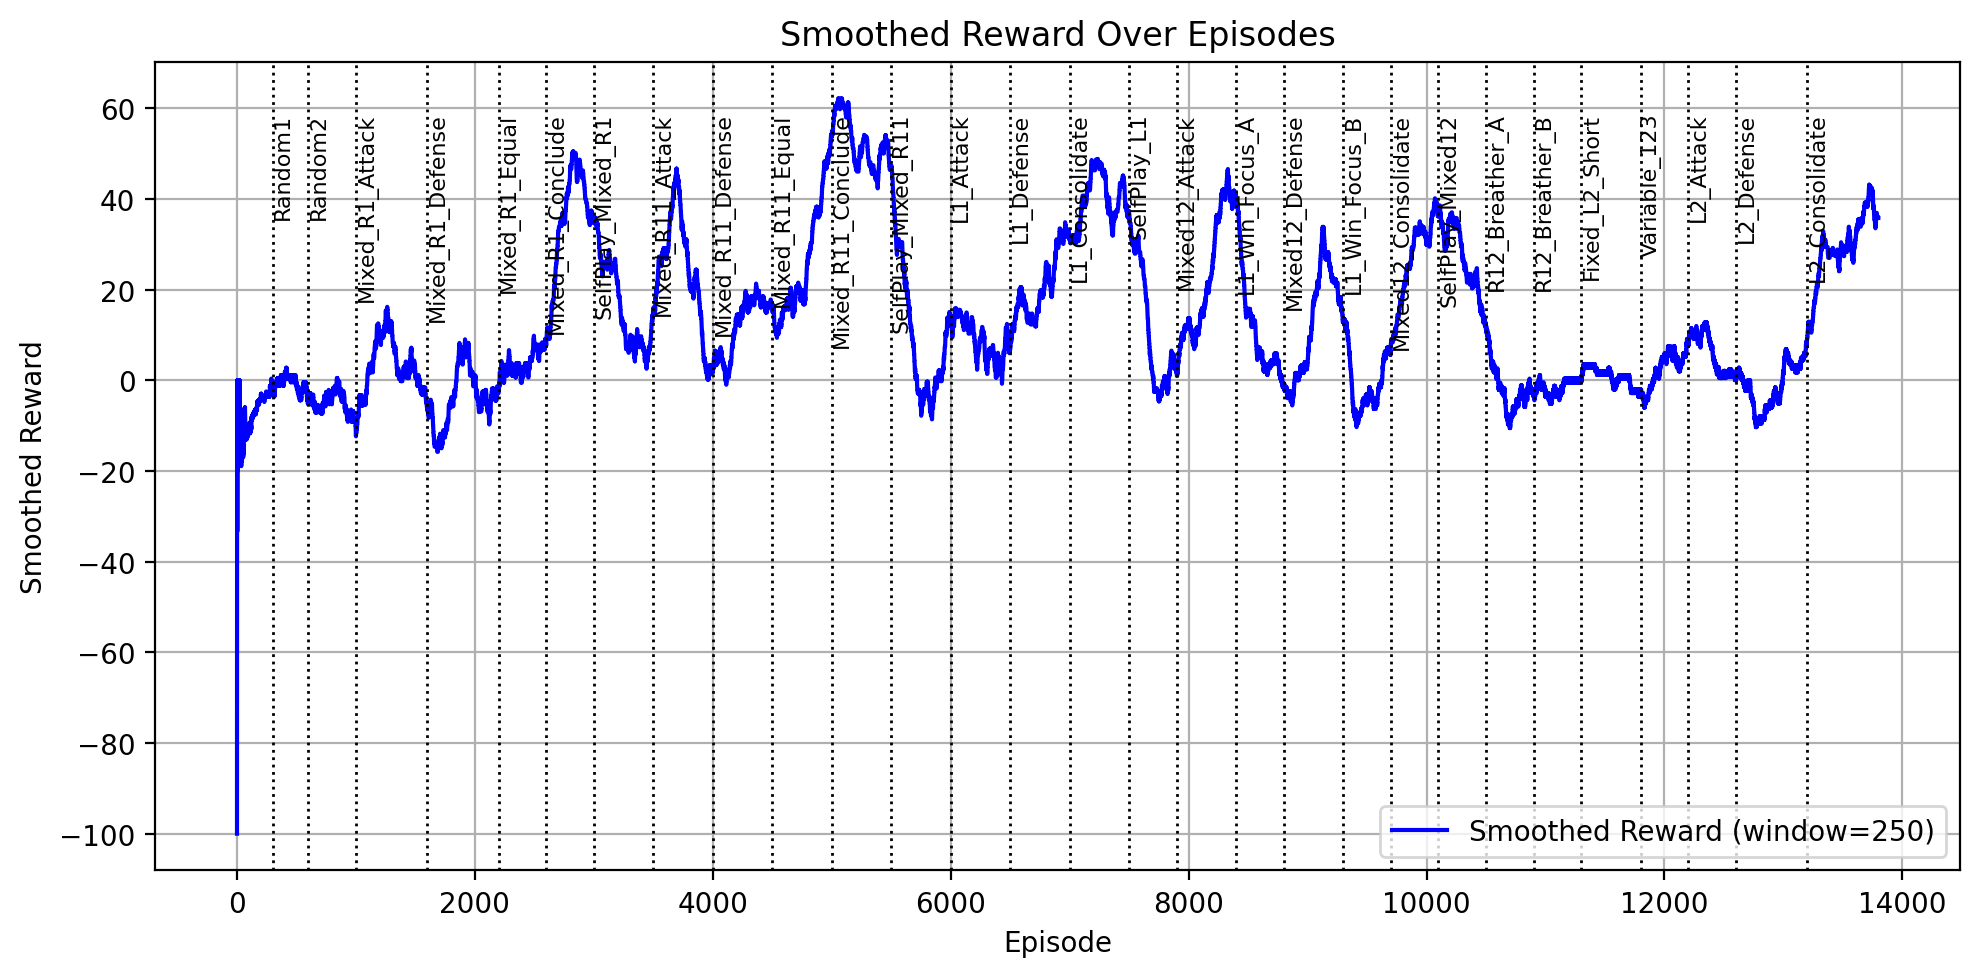

Smoothed reward plot saved to Plots/DQN/DQN-SelfPlay_L2-13800-TU-200-BS-128_final_reward_smoothed.png


In [21]:
window = 250
smoothed = [np.mean(reward_history[max(0, i - window):i + 1]) for i in range(len(reward_history))]

final_reward_fig, final_reward_ax = plt.subplots(figsize=(10, 5))
final_reward_ax.plot(smoothed, label=f"Smoothed Reward (window={window})", color='blue')

# --- Add phase transitions ---
for name, meta in TRAINING_PHASES.items():
    ep = meta["length"]
    if ep is not None and ep <= len(reward_history):
        final_reward_ax.axvline(x=ep, color='black', linestyle='dotted', linewidth=1)
        final_reward_ax.text(ep + 5, max(smoothed) * 0.95, name,
                             rotation=90, va='top', ha='left', fontsize=8)

final_reward_ax.set_title("Smoothed Reward Over Episodes")
final_reward_ax.set_xlabel("Episode")
final_reward_ax.set_ylabel("Smoothed Reward")
final_reward_ax.legend()
final_reward_ax.grid(True)
final_reward_fig.tight_layout()

# --- Show plot ---
plt.show()

# --- Save to file ---
final_reward_fig.savefig(f"{PLOTS}DQN-{TRAINING_SESSION}_final_reward_smoothed.png")
plt.close(final_reward_fig)
print(f"Smoothed reward plot saved to {PLOTS}DQN-{TRAINING_SESSION}_final_reward_smoothed.png")


## Save model

In [22]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
model_path = f"{MODEL_DIR}{TRAINING_SESSION}_Connect4 dqn_model_{timestamp} episodes-{num_episodes} lookahead-{lookahead_depth}.pt"
default_model_path = "Connect4 DQN model.pt"

torch.save(agent.model.state_dict(), model_path)
torch.save(agent.model.state_dict(), default_model_path)
print(f"Model saved to {model_path}")


Model saved to Models/DQN/SelfPlay_L2-13800-TU-200-BS-128_Connect4 dqn_model_20250828-213303 episodes-13800 lookahead-7.pt


## Load model

In [23]:
agent = DQNAgent(device=device)  # Fresh agent instance
state_dict = torch.load(default_model_path, map_location=device, weights_only=True)
agent.model.load_state_dict(state_dict)
agent.update_target_model()
agent.epsilon = 0.0  # Fully greedy — no exploration
print("✅ Trained model loaded and ready for evaluation.")


✅ Trained model loaded and ready for evaluation.


# Evaluation

In [24]:
# === Pure-model evaluation ( ===
# Opponents and games
evaluation_opponents = {
    "Random": 203,
    "Lookahead-1": 101,
    "Lookahead-2": 53,
    "Lookahead-3": 11,
}
evaluation_results = {}

# Make model deterministic & greedy
agent_model_mode  = agent.model.training
agent_target_mode = agent.target_model.training
_eps_backup, _epsmin_backup = agent.epsilon, agent.epsilon_min

agent.model.eval()
agent.target_model.eval()
agent.epsilon = 0.0
agent.epsilon_min = 0.0

start_time = time.time()

for label, num_games in evaluation_opponents.items():
    wins = losses = draws = 0
    depth = int(label.split("-")[1]) if label.startswith("Lookahead") else None

    with tqdm(total=num_games, desc=f"Opponent: {label}") as pbar:
        for game_index in range(num_games):
            state = env.reset()
            # Alternate starters; agent is +1 in this env
            env.current_player = 1 if (game_index % 2 == 0) else -1
            #env.current_player = 1 

            done = False
            while not done:
                valid_actions = env.available_actions()

                if env.current_player == 1:
                    # --- Pure model forward, mask illegal, argmax ---
                    with torch.no_grad():
                        x = build_input(agent, state, device)                 # (1, C, 6, 7)
                        q = agent.model(x).squeeze(0).detach().cpu().numpy()  # (7,)
                    mask = np.full_like(q, -1e9, dtype=np.float32)
                    for a in valid_actions:
                        mask[a] = 0.0
                    action = int(np.argmax(q + mask))
                    if action not in valid_actions:
                        action = random.choice(valid_actions)
                else:
                    # Opponent move
                    if label == "Random":
                        action = random.choice(valid_actions)
                    else:
                        action = Lookahead.n_step_lookahead(np.array(state), -1, depth=depth)
                        if action not in valid_actions:
                            action = random.choice(valid_actions)

                state, _, done = env.step(action)

            # Tally from agent’s perspective (+1 is agent)
            if env.winner == 1:
                wins += 1
            elif env.winner == -1:
                losses += 1
            else:
                draws += 1

            pbar.update(1)

    evaluation_results[label] = {
        "wins": wins,
        "losses": losses,
        "draws": draws,
        "win_rate": round(wins / num_games, 3),
        "loss_rate": round(losses / num_games, 3),
        "draw_rate": round(draws / num_games, 3),
    }

elapsed = time.time() - start_time
print(f"Evaluation completed in {elapsed/60:.1f} minutes")

Opponent: Lookahead-3: 100%|██████████| 11/11 [00:42<00:00,  3.87s/it]

Evaluation completed in 2.0 minutes



📊 Evaluation Summary:
Random: 164W / 39L / 0D → Win: 80.8%, Loss: 19.2%, Draw: 0.0%
Lookahead-1: 51W / 50L / 0D → Win: 50.5%, Loss: 49.5%, Draw: 0.0%
Lookahead-2: 0W / 53L / 0D → Win: 0.0%, Loss: 100.0%, Draw: 0.0%
Lookahead-3: 0W / 11L / 0D → Win: 0.0%, Loss: 100.0%, Draw: 0.0%
📊 Plot saved to Plots/DQN/DQN-SelfPlay_L2-13800-TU-200-BS-128-evaluation_plot.png


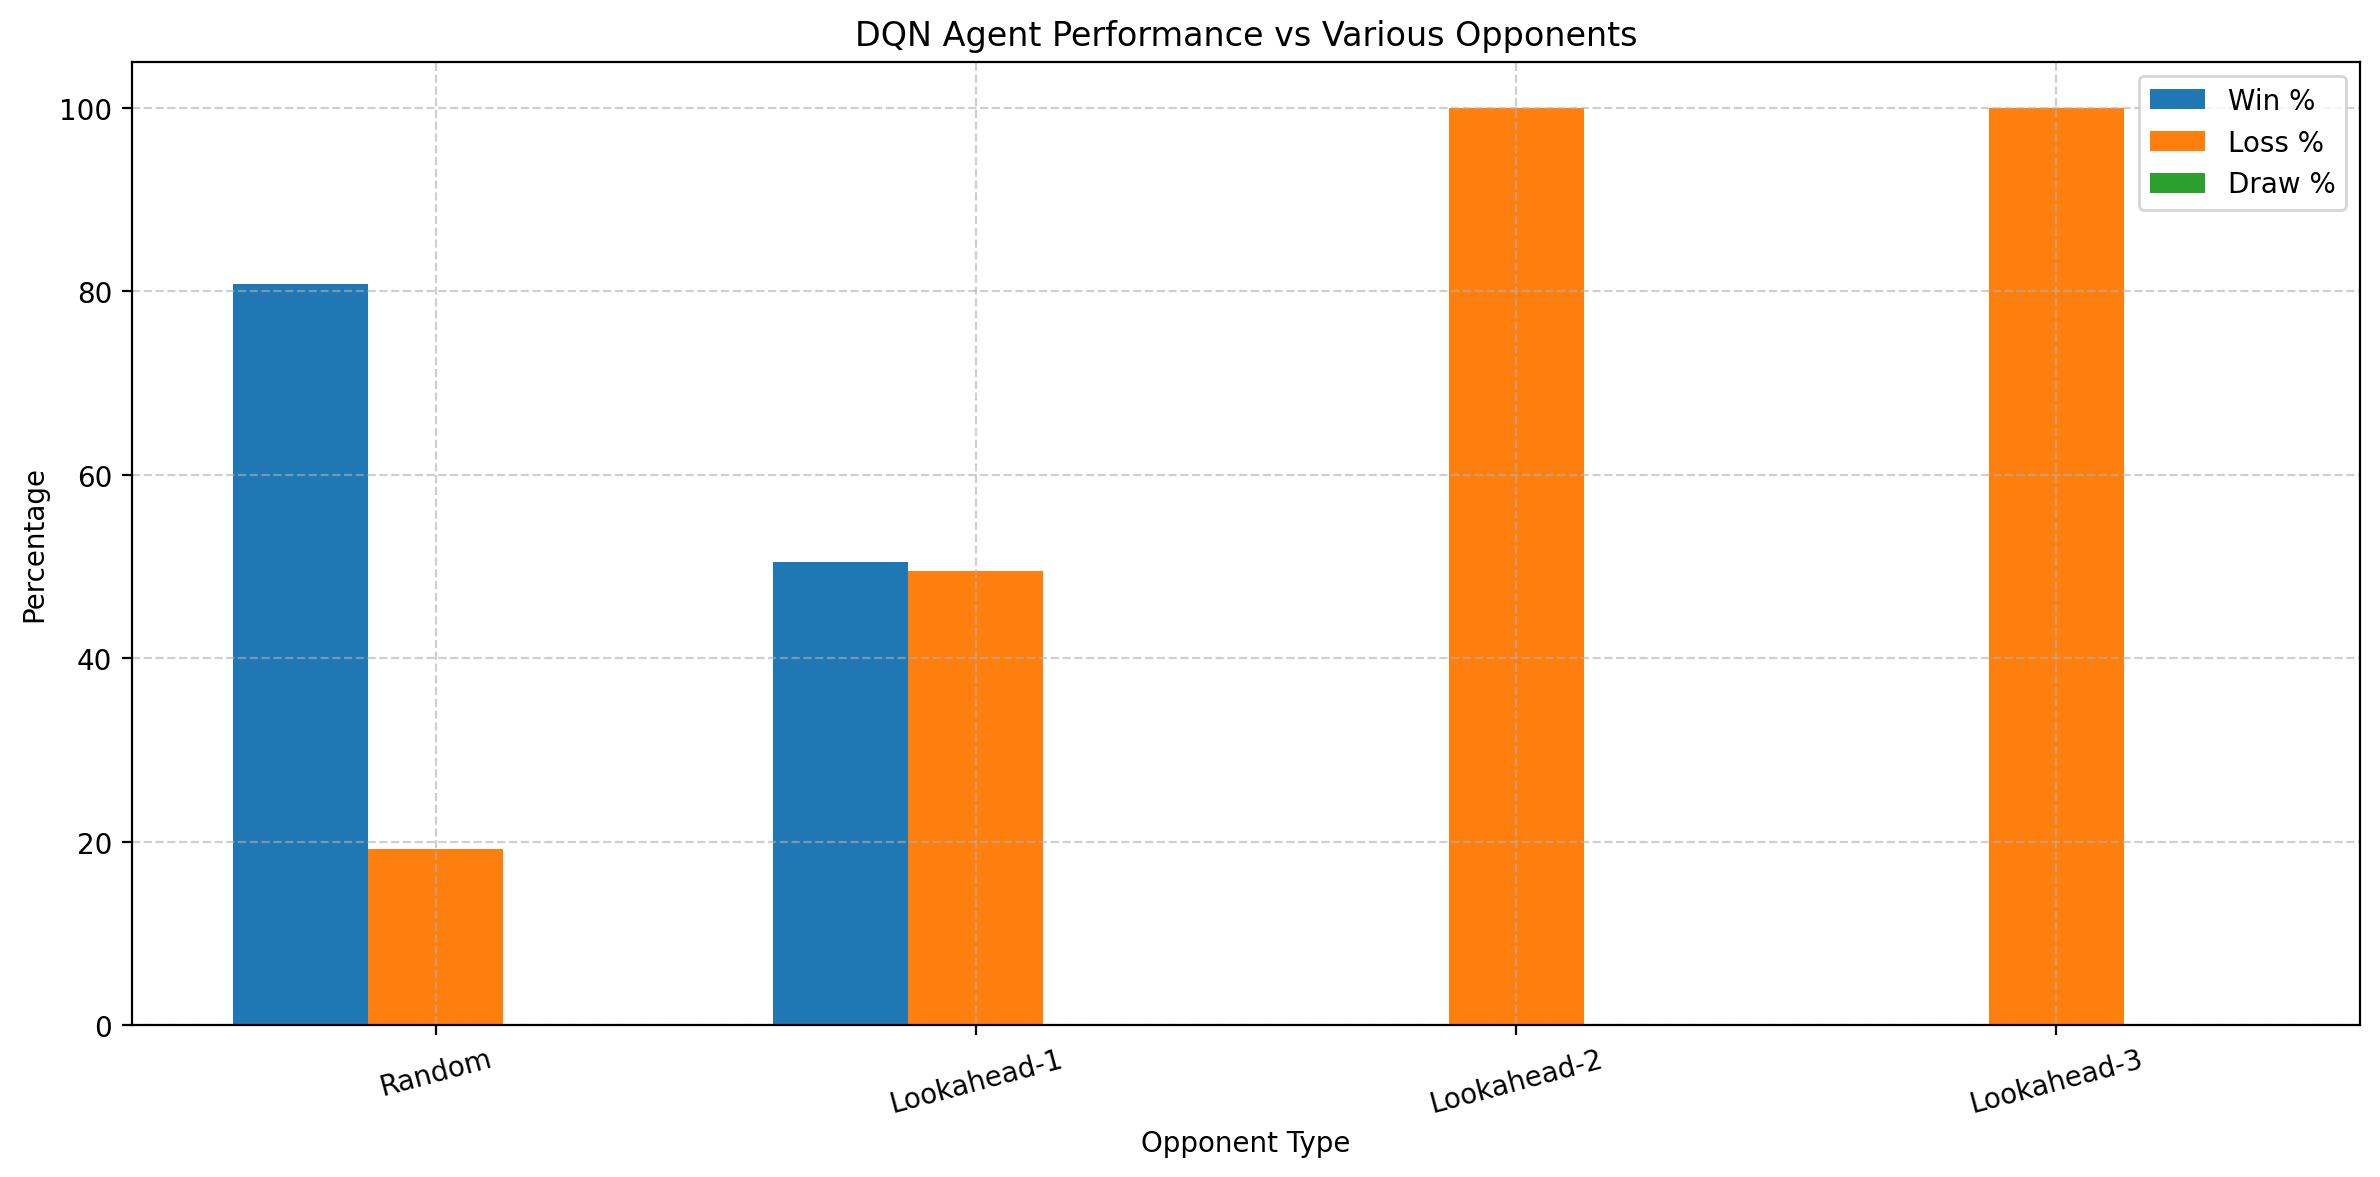

In [25]:
# === Print Summary ===
print("\n📊 Evaluation Summary:")
for label, stats in evaluation_results.items():
    print(f"{label}: {stats['wins']}W / {stats['losses']}L / {stats['draws']}D → "
          f"Win: {stats['win_rate']*100:.1f}%, Loss: {stats['loss_rate']*100:.1f}%, Draw: {stats['draw_rate']*100:.1f}%")

# === Bar Plot Summary ===
labels = list(evaluation_results.keys())
win_rates  = [evaluation_results[k]['win_rate']  * 100 for k in labels]
loss_rates = [evaluation_results[k]['loss_rate'] * 100 for k in labels]
draw_rates = [evaluation_results[k]['draw_rate'] * 100 for k in labels]

x = range(len(labels))
bar_width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x, win_rates, width=bar_width, label='Win %')
plt.bar([i + bar_width for i in x], loss_rates, width=bar_width, label='Loss %')
plt.bar([i + 2 * bar_width for i in x], draw_rates, width=bar_width, label='Draw %')
plt.xlabel('Opponent Type')
plt.ylabel('Percentage')
plt.title('DQN Agent Performance vs Various Opponents')
plt.xticks([i + bar_width for i in x], labels, rotation=15)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plot_path = f"{PLOTS}DQN-{TRAINING_SESSION}-evaluation_plot.png"
plt.savefig(plot_path, dpi=150)
print(f"📊 Plot saved to {plot_path}")

plt.show()

# Save results
df_eval = pd.DataFrame.from_dict(evaluation_results, orient='index')
df_eval.index.name = "Opponent"
# Use Excel if available; otherwise fall back to CSV
try:
    df_eval.to_excel(f"{LOG_DIR}DQN-{TRAINING_SESSION}-evaluation_results.xlsx", index=True)
except Exception as e:
    print("Excel export failed, saving CSV instead:", e)
    df_eval.to_csv(f"{LOG_DIR}DQN-{TRAINING_SESSION}-evaluation_results.csv", index=True)


# DONE

In [26]:
total_end_time = time.time()
total_elapsed = (total_end_time - begin_start_time) / 3600
print(f"Evaluation completed in {total_elapsed:.1f} hours")

Evaluation completed in 6.7 hours


## Training log

In [27]:
# TRAINING_SESSION

training_log_file = "DQN training_sessions.xlsx"
log_row = {"TRAINING_SESSION": TRAINING_SESSION, "TIME [h]": total_elapsed, "EPISODES": num_episodes}

for label, stats in evaluation_results.items():
    log_row[label] = stats["win_rate"]

# === Load or Create Excel File ===
if os.path.exists(training_log_file):
    df_log = pd.read_excel(training_log_file)
else:
    df_log = pd.DataFrame()

# === Append and Save ===
df_log = pd.concat([df_log, pd.DataFrame([log_row])], ignore_index=True)
df_log.to_excel(training_log_file, index=False)

print(f"\n📁 Training session logged to: {training_log_file}")


📁 Training session logged to: DQN training_sessions.xlsx
